In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skspatial.objects import Line
import cv2

## variables

In [2]:
#w = 693 #sticky note pixel width
#W = 0.076 #mm per pixel
#P = 3024 #pixel width of the image
##S = 0.007470#1.22e-6 * P
##f = 0.052
#S = 0.008466 # camera sensor size
#f = 0.028 # focal length
#F = f * P / S
#D = (W * F)/w  # distance to the object
#print(D)
#
#ratio=0.076/w  #um per pixel
#pupil_pixel_size = 44
#r_p = pupil_pixel_size*ratio/2 # pupil radius in mm
#print(r_p)

In [3]:
#im = "0091_H_R" # -6.0
im = "0088_V_L" # -1.75

D = 1.4           # object distance
r_p = 0.004 # radius of pupil
e = 0.006       # eccentricity of light source
R = -0.75          # corrective lens diopter
D_cyl = -0.5     # cylinder lens diopter
axis = 12        # axis of cylinder lens
eps = 1e-4       
axis = np.deg2rad(axis-90 + eps) # convert axis to radians

l_eye = 1/60    # focal length of the eye

f_n = 1/(1/l_eye + 1/D) # focal length of normal eye
f_e = 1/(1/f_n + R) # focal length of eye with error
f_e_cyl = 1/(1/f_n + R + D_cyl) # focal length of eye with error and cylinder lens
x = abs(1/R)


## ray tracing

In [4]:
def length(v):
    return np.linalg.norm(v)

def normalize(v):
    return v / np.linalg.norm(v)

In [5]:
camera = (0, 0, D)
light = (0, e, D)
#light = (-e, 0, D)
lens = (0, 0, 0)
retina = (0, 0, -l_eye)

In [6]:
class Ray():
    def __init__(self, start, end):
        start = np.array(start)
        end = np.array(end)
        self.start = np.array(start)
        self.end = np.array(end)
        self.dir = self.end - self.start
        self.dir = self.dir / np.linalg.norm(self.dir)

    def intersect(self, ray):
        # check if the rays are parallel
        line_a = Line(point=self.start, direction=self.dir)
        line_b = Line(point=ray.start, direction=ray.dir)
        intersection = line_a.intersect_line(line_b)
        return intersection

In [7]:
def intersect_rays(ray1, ray2):
    # check if the rays are parallel
    line_a = Line(point=ray1.start, direction=ray1.dir)
    line_b = Line(point=ray2.start, direction=ray2.dir)
    intersection = line_a.intersect_line(line_b)
    return intersection

In [8]:
class Plane():
    def __init__(self, point, normal):
        self.normal = normal
        self.point = point

    def init_from_points(point1, point2, point3):
        v1 = point2 - point1
        v2 = point3 - point1
        normal = np.cross(v1, v2)
        point = point1
        return Plane(point, normal)

    def intersect(self, ray):
        # check if the ray is parallel to the plane
        if np.dot(ray.dir, self.normal) == 0:
            return None
        # calculate intersection point
        t = np.dot(self.point - ray.start, self.normal) / np.dot(ray.dir, self.normal)
        return ray.start + t * ray.dir

In [9]:
class Sphere():
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def intersect(self, ray, mode='first'):
        # calculate intersection point
        a = np.dot(ray.dir, ray.dir)
        b = 2 * np.dot(ray.dir, ray.start - self.center)
        c = np.dot(ray.start - self.center, ray.start - self.center) - self.radius**2
        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            return None
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)
        if mode == 'first':
            return ray.start + min(t1, t2) * ray.dir
        elif mode == 'second':
            return ray.start + max(t1, t2) * ray.dir
        else:
            return None

In [10]:
class Lens():
    def __init__(self, center, normal, focal_length, focal_length_ast, axis):
        self.center = np.array(center)
        self.normal = np.array(normal)
        self.normal = self.normal/np.linalg.norm(self.normal)

        self.focal_length = focal_length
        self.focal_length_ast = focal_length_ast
        self.axis = axis

    def intersect(self, ray):
        # calculate intersection point of ray and lens
        t = np.dot(self.center - ray.start, self.normal) / np.dot(ray.dir, self.normal)
        intersection = ray.start + t * ray.dir
        return intersection
    
    def refract(self, ray):
        hit = self.intersect(ray)
        # calculate refracted ray
        hit_dir = hit - self.center
        axis_vector = np.array([np.cos(self.axis), np.sin(self.axis), 0])
        angle = np.arccos(np.dot(hit_dir, axis_vector) / (np.linalg.norm(hit_dir) * np.linalg.norm(axis_vector)))

        focal_length = 1/(1/f_n + R + pow(np.sin(angle), 2) * D_cyl) # TODO  PARAXIAL APPROXIMATION 
        focal_point = self.center - self.normal * focal_length


        center_ray = Ray(ray.start, self.center)
        orthogonal_ray = Ray(ray.start, ray.start-self.normal)
        if not np.array_equal(orthogonal_ray.dir, center_ray.dir):
            ortho_hit = self.intersect(orthogonal_ray)
            ortho_refract = Ray(ortho_hit, focal_point)
            image_point = intersect_rays(center_ray, ortho_refract)
        else:
            im_distance = 1/(1/focal_length - 1/np.linalg.norm(self.center - orthogonal_ray.start))
            image_point = self.center - self.normal * im_distance
        refracted_ray = Ray(hit, image_point)
        return refracted_ray


        

In [11]:
lens_object = Lens(lens, np.array((0, 0, 1)), f_e, f_e_cyl, axis)
#retina_object = Plane(retina, np.array((0, 0, 1)))
sphere_center = retina + np.array([0, 0, -l_eye/2])
retina_object = Sphere(sphere_center, l_eye/2)

a = np.cos(axis) * r_p
b = np.sin(axis) * r_p
c = np.cos(axis+np.pi/2) * r_p
d = np.sin(axis+np.pi/2) * r_p

# cast rays from camera to 4 corners of the lens
camera_rays = []
camera_rays.append(Ray(camera, lens+ np.array((a,  b,  0))))
camera_rays.append(Ray(camera, lens+ np.array((-a, -b, 0)))) # top of crescent
camera_rays.append(Ray(camera, lens+ np.array((c,  d,  0))))
camera_rays.append(Ray(camera, lens+ np.array((-c, -d, 0))))
camera_ray_focus = camera_rays[0].intersect(camera_rays[1])
camera_hits = []

refracted_camera_rays = []
for ray in camera_rays:
    ray = lens_object.refract(ray)
    refracted_camera_rays.append(ray)
    hit = retina_object.intersect(ray)
    camera_hits.append(hit)
camera_ray_focus = refracted_camera_rays[0].intersect(refracted_camera_rays[1])
camera_ray_focus2 = refracted_camera_rays[2].intersect(refracted_camera_rays[3])
image_point_cam = np.mean([camera_ray_focus, camera_ray_focus2], axis=0)

camera_hits = np.array(camera_hits)

light_rays = []
light_rays.append(Ray(light, lens+ np.array((a,  b,  0))))
light_rays.append(Ray(light, lens+ np.array((-a, -b, 0)))) # top of crescent
light_rays.append(Ray(light, lens+ np.array((c,  d,  0))))
light_rays.append(Ray(light, lens+ np.array((-c, -d, 0))))
light_hits = []

refracted_light_rays = []
for ray in light_rays:
    ray = lens_object.refract(ray)
    refracted_light_rays.append(ray)
    hit = retina_object.intersect(ray)
    light_hits.append(hit)
light_ray_focus1 = refracted_light_rays[0].intersect(refracted_light_rays[1])
light_ray_focus2 = refracted_light_rays[2].intersect(refracted_light_rays[3])
image_point = np.mean([light_ray_focus1, light_ray_focus2], axis=0)
light_hits = np.array(light_hits)

sturm_plane1 = Plane(light_ray_focus1, normalize(camera))
sturm_line1_1 = sturm_plane1.intersect(refracted_light_rays[2])
sturm_line1_2 = sturm_plane1.intersect(refracted_light_rays[3])
sturm_plane2 = Plane(light_ray_focus2, normalize(camera))
sturm_line2_1 = sturm_plane2.intersect(refracted_light_rays[0])
sturm_line2_2 = sturm_plane2.intersect(refracted_light_rays[1])

In [12]:
light_ray_focus1, light_ray_focus2

(Point([ 0.00000000e+00, -7.23327306e-05, -1.68776371e-02]),
 Point([ 8.67361738e-19, -7.29483283e-05, -1.70212766e-02]))

In [13]:
class Camera():
    def __init__(self, loc, lookat, up, windowWidth=100, windowHeight=100):
        self.loc = loc
        self.lookat = lookat
        self.up = up
        w = lookat - loc
        self.focus = length(w)
        self.right = normalize(np.cross(self.up, w)) * r_p*2
        self.up = normalize(np.cross(w, self.right)) * r_p*2
    
        self.windowWidth = windowWidth
        self.windowHeight = windowHeight
        
    def getRay(self, X, Y):
        direction = self.lookat + self.right * (2.0 *(X + 0.5) / self.windowWidth - 1) + self.up * (2.0 *(Y + 0.5) / self.windowHeight - 1) - self.loc
        return Ray(self.loc, direction)

## TRACING

In [14]:
w_width = 100
w_height = w_width
cam = Camera(camera, np.array((0, 0, 0)), np.array((0, 1, 0)), windowWidth=w_width, windowHeight=w_height)

In [15]:
kd = np.array([0.93333333, 0.31764706, 0.25098039])*0.15
ka = np.array([0.93333333, 0.31764706, 0.25098039]) * 0.25
ks = np.array([1, 1, 0.4])*1.2
shininess = 20

La = np.array([1, 1, 1])*4
Le = np.array([1, 1, 1])*2

In [16]:
def colorNoise(scale=0.1):
    return np.random.normal(0.5, 0.5, 3)*scale

In [17]:
def trace(ray, q=2, ql=2, qp=2, noise=True):
    if noise:
        color_noise = colorNoise(0.05)
    else:
        color_noise = np.zeros(3)
    outRadience = np.zeros(3)

    lens_hit = lens_object.intersect(ray)
    dist_from_center = length(lens_hit - lens_object.center)
    if noise:
        lens_distortion = 1 - (dist_from_center / r_p) ** q
    else:
        lens_distortion = 1
        
    if length(lens_hit - lens_object.center) > r_p:
        return outRadience
    outRadience += ka * La

    camera_ray = lens_object.refract(ray)
    retina_hit = retina_object.intersect(camera_ray)

    # calculate light ray
    if D_cyl != 0:
        light_plane = Plane.init_from_points(sturm_line1_1, sturm_line1_2, retina_hit)
        sturm_line_2 = Ray(sturm_line2_1, sturm_line2_2)
        sturm_line_2_hit = light_plane.intersect(sturm_line_2)
        light_ray = Ray(sturm_line_2_hit, retina_hit)
    else:
        light_ray = Ray(image_point, retina_hit)

    entry_point = lens_object.intersect(light_ray)
    if length(entry_point - lens_object.center) > r_p:
        return (outRadience + color_noise) * lens_distortion
    light_dist_from_center = length(entry_point - lens_object.center)
    if noise:
        light_distortion = 1 - (light_dist_from_center / r_p) ** ql
        compound_distortion = 1 - ((dist_from_center + light_dist_from_center) / (2*r_p)) ** qp
    else:
        light_distortion = 1
        compound_distortion = 1
    
    d_inside = length(retina_hit - entry_point)
    d_outside = length(entry_point - light)
    d_sum = d_inside + d_outside

    normal = normalize(retina_hit - retina_object.center)

    if R > 0:
        light_ray.dir = -light_ray.dir
    cosTheta = np.dot(light_ray.dir, normal)
    if cosTheta > 0:
        LeIn = Le / (d_sum**2) * light_distortion * compound_distortion
        outRadience += kd * LeIn * cosTheta
        halfway = normalize(light_ray.dir - camera_ray.dir)


        cosDelta = np.dot(halfway, normal)
        if cosDelta > 0:
            outRadience += LeIn * ks * pow(cosDelta, shininess)
    
    return (outRadience + color_noise) * lens_distortion

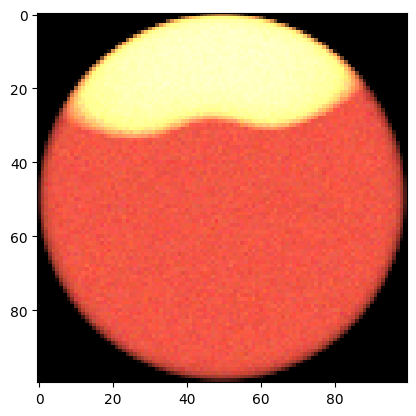

In [25]:
image = np.zeros((w_height, w_width, 3), dtype=np.uint8)

for x in range(w_width):
    for y in range(w_height):
        ray = cam.getRay(x, y)
        outRadience = trace(ray, 40, 15, 10, noise=True)
        outRadience = np.clip(outRadience, 0, 1) * 255
        image[y, x] = outRadience

plt.imshow(image)

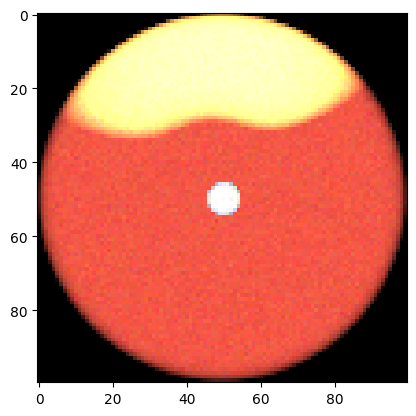

In [26]:
# add white specular reflection to center of eye
center = (int(w_width/2), int(w_height/2))
reflection_radius = 5
for x in range(w_width):
    for y in range(w_height):
        d = length(np.array([x, y]) - np.array(center))
        if d < reflection_radius:
            intensity = 1 - (d / reflection_radius)**10
            c = np.array([255, 255, 255])*intensity + colorNoise(0.1) * 255
            c = np.clip(c, 0, 255)
            image[y, x] = c
plt.imshow(image)

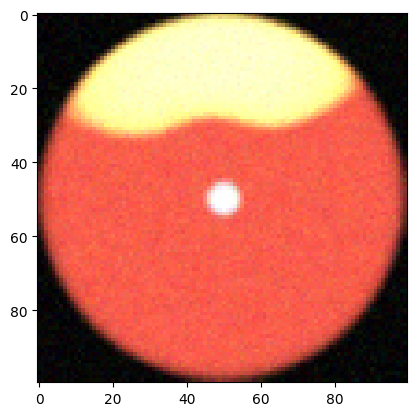

In [27]:
# noise the whole image with a gaussian filter
noised = cv2.GaussianBlur(image, (3, 3), 1)
# add some noise
for x in range(w_width):
    for y in range(w_height):
        noised[y, x] = np.clip(noised[y, x] + colorNoise(0.05) * 255, 0, 255)
plt.imshow(noised)

## plotting

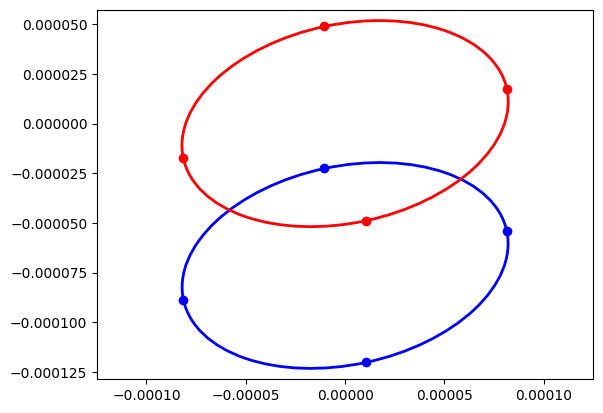

In [21]:
#plot first 2 coords of hits
# set axes equal
light_w = np.linalg.norm(light_hits[0] - light_hits[1])
light_h = np.linalg.norm(light_hits[2] - light_hits[3])
light_center = np.mean(light_hits[0:4], axis=0)
light_ellipse = Ellipse(xy=(light_center[:-1]), width=light_w, height=light_h, angle=np.rad2deg(axis),
                        edgecolor='b', fc='None', lw=2)

camera_w = np.linalg.norm(camera_hits[0] - camera_hits[1])
camera_h = np.linalg.norm(camera_hits[2] - camera_hits[3])
camera_center = np.mean(camera_hits[0:4], axis=0)
camera_ellipse = Ellipse(xy=(camera_center[:-1]), width=camera_w, height=camera_h, angle=np.rad2deg(axis),
                        edgecolor='r', fc='None', lw=2)

fig, ax = plt.subplots()
ax.add_patch(light_ellipse)
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(light_hits[:,0], light_hits[:,1], c='blue')
ax.scatter(camera_hits[:,0], camera_hits[:,1], c='red')

ax.add_patch(camera_ellipse)
plt.show()